In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# Загрузим данные и посмотрим на небольшую часть
data = pd.read_csv('./breast-cancer_1.csv')

In [ ]:
num_cols = [
    'deg-malig',
    'tumor-size',
    'inv-nodes',
    'node-caps',
    'breast',
    'age',
    'irradiat'
]

cat_cols = [
    'menopause',
    'breast-quad'
]

target_col = 'class'

cols = num_cols + cat_cols + [target_col]

In [ ]:
data = data[cols]
# Возраст записан не в виде числа, исправим это, вырезав последний символ и скастовав к числу
data['age'] = data['age'].str.slice(0, -3).astype(int)

data['tumor-size'] = data['tumor-size'].str.slice(0, -2)
data['tumor-size'] = data['tumor-size'].str.replace('-', '').astype(int) + 2

data['inv-nodes'] = data['inv-nodes'].str.slice(0, -2)
data['inv-nodes'] = data['inv-nodes'].str.replace('-', '').astype(int) + 1

data['node-caps'] = (data['node-caps'] == 'yes').astype(int)
data['irradiat'] = (data['irradiat'] == 'yes').astype(int)
data['breast'] = (data['breast'] == 'right').astype(int)
data['class'] = (data['class'] == 'recurrence-events').astype(int)

data = data.loc[data['breast-quad'] != '?']

In [ ]:
# Задание: Теперь добавьте в датафрейм колонки для всех категориальных фичей и обновите список категориальных фичей
data = pd.get_dummies(data, columns=cat_cols)
cat_cols_new = []
for col_name in cat_cols:
    cat_cols_new.extend(filter(lambda x: x.startswith(col_name), data.columns))
cat_cols = cat_cols_new

In [ ]:
from imblearn.over_sampling import ADASYN

In [ ]:
X = data[num_cols + cat_cols].to_numpy()
print(X.shape)
y = data['class'].to_numpy()
print(y.shape)
ros = ADASYN(random_state=0)
X_res, y_res = ros.fit_resample(X, y)
print(X_res.shape)
print(y_res.shape)

(285, 15)
(285,)
(412, 15)
(412,)


In [ ]:
import random
import torch

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_res, 
    y_res, 
    test_size=0.3, 
    shuffle=True)

X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.FloatTensor(y_train)
y_test = torch.FloatTensor(y_test)

In [ ]:
from sklearn.preprocessing import StandardScaler

pca = StandardScaler()
pca.fit(X_train)
# Выход pca - numpy матрица, положим ее в новую переменную со всеми фичами
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)

In [ ]:
class WineNet(torch.nn.Module):
    def __init__(self, n_hidden_neurons):
        super(WineNet, self).__init__()
        
        self.fc1 = torch.nn.Linear(15, n_hidden_neurons)
        self.activ1 = torch.nn.Sigmoid()
        self.fc2 = torch.nn.Linear(n_hidden_neurons, n_hidden_neurons)
        self.activ2 = torch.nn.Sigmoid()
        self.fc3 = torch.nn.Linear(n_hidden_neurons, 1)
        self.sm = torch.nn.Sigmoid()
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.activ1(x)
        x = self.fc2(x)
        x = self.activ2(x)
        x = self.fc2(x)
        #x = self.activ2(x)
        #x = self.fc2(x)
        x = self.activ1(x)
        x = self.fc3(x)
        return x

    def inference(self, x):
        x = self.forward(x)
        x = self.sm(x)
        return x
    
wine_net = WineNet(45)

In [ ]:
loss = torch.nn.BCEWithLogitsLoss()

optimizer = torch.optim.Adam(wine_net.parameters(), lr=0.0003)

In [ ]:
batch_size = 25

def closure():
  preds = wine_net.forward(x_batch)
  loss_value = loss(preds.flatten(), y_batch)
  loss_value.backward()
  return loss_value

for epoch in range(1200):
    order = np.random.permutation(len(X_train))
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]
        
        x_batch = X_train[batch_indexes]
        y_batch = y_train[batch_indexes]
        
        preds = wine_net.forward(x_batch)
        
        loss_value = loss(preds.flatten(), y_batch)
        loss_value.backward()
        
        optimizer.step()
        
    if epoch % 100 == 0:
        train_preds = 1 / (1 + torch.exp(-preds))
        train_preds = (train_preds > 0.5).float().flatten()
        print('train: ', (train_preds == y_batch).float().mean())
        test_preds = wine_net.inference(X_test)
        test_preds = (test_preds > 0.5).float().flatten()
        print((test_preds == y_test).float().mean())

train:  tensor(0.4615)
tensor(0.4435)
train:  tensor(0.7692)
tensor(0.7903)
train:  tensor(0.8462)
tensor(0.7661)
train:  tensor(0.7692)
tensor(0.7823)
train:  tensor(0.8462)
tensor(0.7823)
train:  tensor(0.6923)
tensor(0.7661)
train:  tensor(0.7692)
tensor(0.7581)
train:  tensor(0.7692)
tensor(0.7984)
train:  tensor(0.8462)
tensor(0.8065)
train:  tensor(0.8462)
tensor(0.7984)
train:  tensor(0.8462)
tensor(0.7742)
train:  tensor(0.8462)
tensor(0.7581)


In [ ]:
from sklearn import metrics

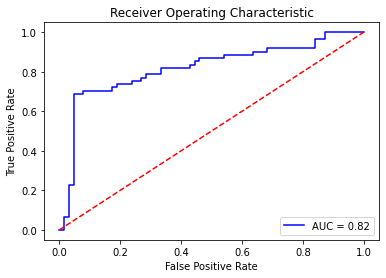

In [ ]:
# calculate the fpr and tpr for all thresholds of the classification
preds = wine_net.inference(X_test).detach().numpy()
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

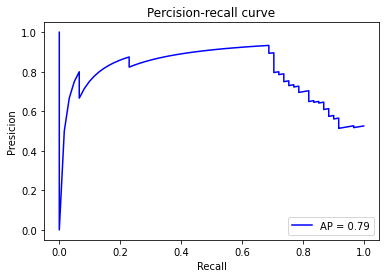

In [ ]:
# precision-recall curve
presicion, recall, threshold = metrics.precision_recall_curve(y_test, preds)
ap = metrics.average_precision_score(y_test, preds)
plt.title('Percision-recall curve')
plt.plot(recall, presicion, 'b', label = 'AP = %0.2f' % ap)
plt.legend(loc = 'lower right')
plt.ylabel('Presicion')
plt.xlabel('Recall')
plt.show()